In [1]:
!pip install tensorflow

In [2]:
!pip install tqdm

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph, Source
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import PIL
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [4]:
version = 12
folder = f"/Users/yaeerk/Documents/NAYA/FinalProject/QRcode{version}"

dataset_max_size = 30000

sub_folders = ("benign", "malware", "defacement", "phishing")
cnt_folders = (dataset_max_size * 3, dataset_max_size, dataset_max_size, dataset_max_size)               
cls_folders = (0, 1, 1, 1)
new_labels = ("benign", "malicious")

random_state = 43021
train_size = 0.8
epochs = 25
batch_size = 128
steps_per_epoch = dataset_max_size // batch_size

filename = f"{dataset_max_size}-{train_size}-{epochs}-{steps_per_epoch}-{version}"
save_path = "/tmp/qrcode/"

In [5]:
if(version == 4):
    image_size = (33, 33)
elif(version == 5):
    image_size = (37, 37)
elif(version == 6):
    image_size = (41, 41)
elif(version == 12):
    image_size = (65, 65)
else:
    image_size = (36, 36)

In [7]:
#https://www.kaggle.com/datasets/samahsadiq/benign-and-malicious-qr-codes

#load the dataset


try:

    #read the images
    with open(save_path + 'multi-qr-image-' + str(dataset_max_size), 'rb') as f:
        X = np.load(f)

    #read the labels
    with open(save_path + 'multi-qr-label-' + str(dataset_max_size), 'rb') as f:
        y_multi = np.load(f)

    print(f"dataset was loaded")
            
except:
       
    X, y_multi = [], []
        
    for p, sub_folder in enumerate(sub_folders):
                         
        X_subfolder, y_multi_subfolder = [], []            

        path = folder + "/" + sub_folder
        image_filenames = [filename for filename in os.listdir(path) if("png" in filename)]

        if(len(image_filenames) > cnt_folders[p]):        
            image_filenames = image_filenames[:cnt_folders[p]]

        for image_filename in tqdm(image_filenames, desc = "Loading " +  sub_folder, ncols = 110):

            try:
                m = Image.open(path + "/" + image_filename)

                #resize to predefined size
                m = m.resize(image_size, resample = PIL.Image.BICUBIC)

                #convert to gray scale
                m = ImageOps.grayscale(m)

                #convert to numpy array and do not rescale, save it in byte (smaller size on disk)
                n = np.array(m.getdata()).reshape(image_size[0], image_size[1], 1) / 255.0

                #append to datasets
                X_subfolder.append(n)                    
                y_multi_subfolder.append(p)

            except:
                print(f"count not load: {image_filenames}")


        #rescale
        X.extend(X_subfolder)
        y_multi.extend(y_multi_subfolder)

    X = np.array(X)
    y_multi = np.array(y_multi)
              
    try:
        #save the images
        with open(save_path + 'multi-qr-image-' + str(dataset_max_size), 'wb') as f:
            np.save(f, X)

        #save the labels
        with open(save_path + 'multi-qr-label-' + str(dataset_max_size), 'wb') as f:
            np.save(f, y_multi)

    except:
        print("unable to save images & labels")

dataset benign was loaded


In [8]:
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X, y_multi, train_size = 0.8, random_state = random_state)

In [50]:
#create also binary labels
def multi_2_binary(x):
    y = []
    for i in range(len(x)):
        y.append(0 if x[i][0] == 1 else 1)
        
    return np.array(y)

y_binary_train = multi_2_binary(y_binary_train)
y_binary_test = multi_2_binary(y_binary_test)

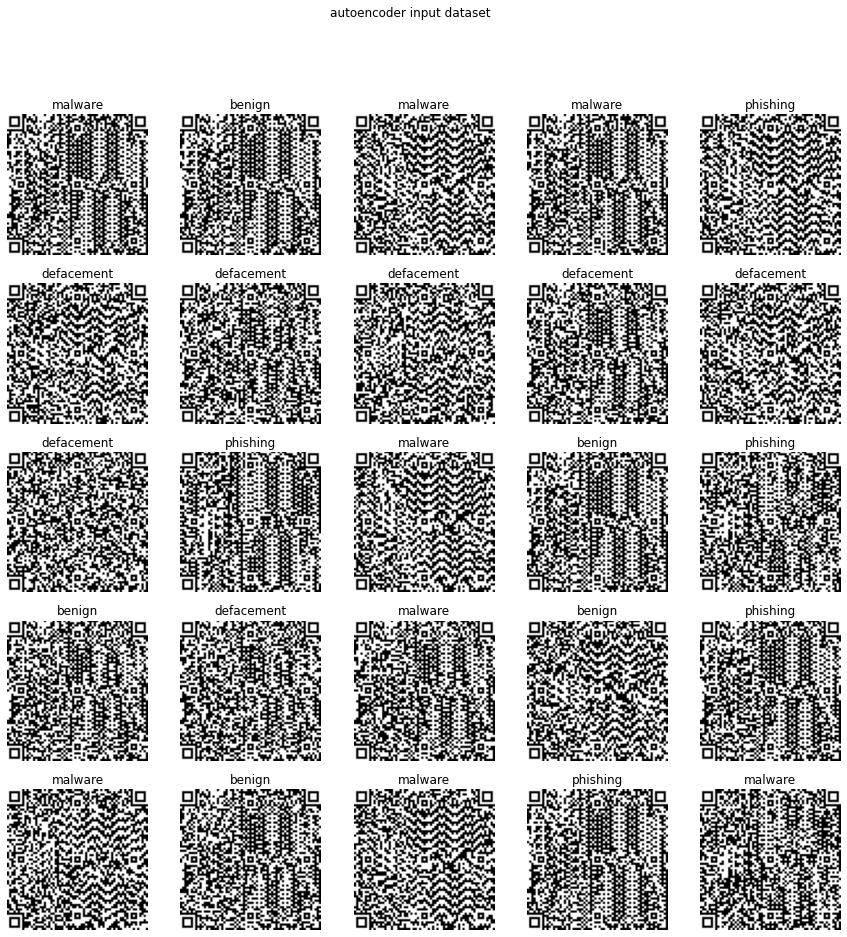

In [55]:
#visualize the input data
fig = plt.figure(figsize = (15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i], cmap = 'binary')
    for j in range(4):
        if(y_multi_test[i][j] > 0):
            plt.title(sub_folders[j])
            break
    plt.axis("off")
    
fig.suptitle('autoencoder input dataset')
plt.savefig(save_path + "autoencoder-" + filename + "-visualization.png")
plt.show()

In [56]:
#trivial autoencoder
autoencoder = tf.keras.Sequential([

    tf.keras.layers.Input(shape = (image_size[0], image_size[1], 1)),

    # Encoder
    layers.Flatten(),
    layers.Dense(12, activation = 'relu'),

    # Decoder
    layers.Dense(image_size[0] * image_size[1], activation = 'sigmoid'),
    tf.keras.layers.Reshape((image_size[0], image_size[1], 1)),    
])

autoencoder.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"])

autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 4225)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                50712     
_________________________________________________________________
dense_3 (Dense)              (None, 4225)              54925     
_________________________________________________________________
reshape_1 (Reshape)          (None, 65, 65, 1)         0         
Total params: 105,637
Trainable params: 105,637
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = autoencoder.fit(
    x = X_train, 
    y = X_train,
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch, 
    
    validation_data = (X_test, X_test),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)])

Epoch 1/25
234/234 [==============================] - 16s 65ms/step - loss: 0.2496 - binary_accuracy: 0.8633 - val_loss: 0.1649 - val_binary_accuracy: 0.9116
Epoch 2/25
234/234 [==============================] - 14s 59ms/step - loss: 0.1554 - binary_accuracy: 0.9133 - val_loss: 0.1489 - val_binary_accuracy: 0.9148
Epoch 3/25
234/234 [==============================] - 16s 71ms/step - loss: 0.1476 - binary_accuracy: 0.9150 - val_loss: 0.1457 - val_binary_accuracy: 0.9155
Epoch 4/25
234/234 [==============================] - 17s 73ms/step - loss: 0.1454 - binary_accuracy: 0.9154 - val_loss: 0.1443 - val_binary_accuracy: 0.9159
Epoch 5/25
234/234 [==============================] - 16s 69ms/step - loss: 0.1442 - binary_accuracy: 0.9157 - val_loss: 0.1434 - val_binary_accuracy: 0.9161
Epoch 6/25
234/234 [==============================] - 16s 67ms/step - loss: 0.1434 - binary_accuracy: 0.9159 - val_loss: 0.1426 - val_binary_accuracy: 0.9162
Epoch 7/25
234/234 [==============================] 

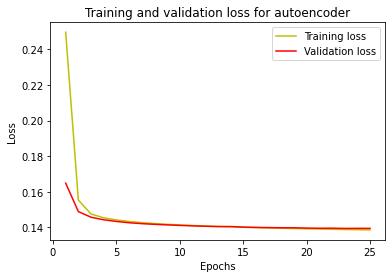

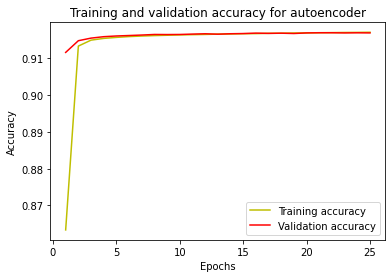

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1, len(loss) + 1)
plt.plot(epoch, loss, 'y', label = 'Training loss')
plt.plot(epoch, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss for autoencoder')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(save_path + "autoencoder-" + filename + "-loss_vs_epoch.png")
plt.show()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
plt.plot(epoch, acc, 'y', label = 'Training accuracy')
plt.plot(epoch, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy for autoencoder')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(save_path + "autoencoder-" + filename + "-accuracy_vs_epoch.png")
plt.show()

In [59]:
#get actual metrics of train data
score_train = autoencoder.evaluate(X_train, X_train)

#get actual metrics of test data
score_test = autoencoder.evaluate(X_test, X_test)

750/750 [==============================] - 3s 4ms/step - loss: 0.1395 - binary_accuracy: 0.9169


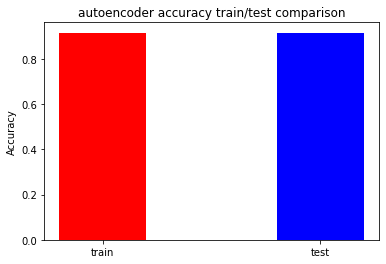

In [60]:
plt.bar(["train", "test"], 
        [score_train[1], score_test[1]],
        color =['red', 'blue'], width = 0.4)
 
plt.ylabel("Accuracy")
plt.title("autoencoder accuracy train/test comparison")
plt.savefig(save_path + "autoencoder-" + filename + "-train-test-accuracy.png")
plt.show()

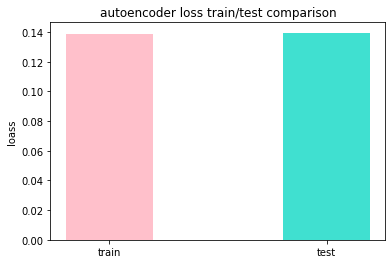

In [61]:
plt.bar(["train", "test"], 
        [score_train[0], score_test[0]],
        color =['pink', 'turquoise'], width = 0.4)
 
plt.ylabel("loass")
plt.title("autoencoder loss train/test comparison")
plt.savefig(save_path + "autoencoder-" + filename + "-train-test-loss.png")
plt.show()

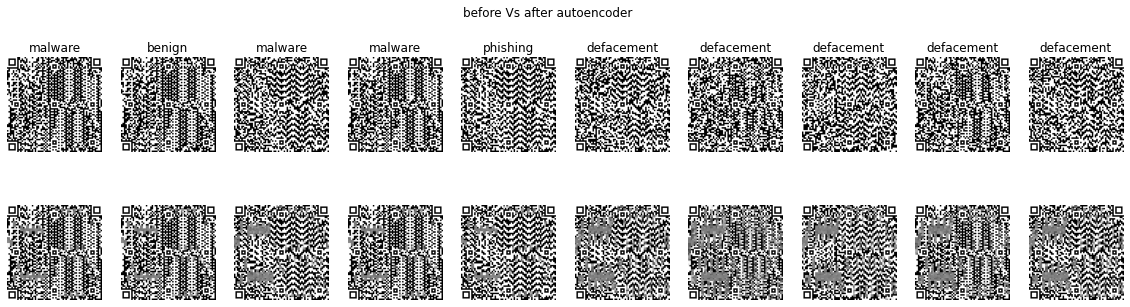

In [62]:
#visualize the autoencoded data
n = 10
y_auto = autoencoder.predict(X_test[:n])
fig = plt.figure(figsize = (20, 5))

for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i], cmap = 'binary')
      
    for j in range(4):
        if(y_multi_test[i][j] > 0):
            plt.title(sub_folders[j])
            break
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_auto[i], cmap = 'binary')

    plt.axis("off")
    
fig.suptitle('before Vs after autoencoder')
plt.savefig(save_path + "autoencoder-" + filename + "-before_and_after.png")

In [63]:
#check accuracy after autoencoder
X_auto = autoencoder.predict(X_test)

In [70]:
#check binary classifier accuracy after autoencoder
binaryclassifier = keras.models.load_model(save_path + "binary-classifier-" + filename)
binaryclassifier.build((None, image_size[0], image_size[1], 1))

binaryclassifier.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"])

binaryclassifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 648)               0

In [71]:
binary_score_test = binaryclassifier.evaluate(X_auto, y_binary_test)

750/750 [==============================] - 8s 10ms/step - loss: 1.1781 - binary_accuracy: 0.5577


In [68]:
#check multi classifier accuracy after autoencoder
multiclassifier_filename = keras.models.load_model(save_path + "multi-classifier-" + filename)
multiclassifier_filename.build((None, image_size[0], image_size[1], 1))

multiclassifier_filename.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "categorical_crossentropy",
    metrics = ["categorical_accuracy"])

multiclassifier_filename.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 648)               0

In [69]:
multi_score_test = multiclassifier_filename.evaluate(X_auto, y_multi_test)

750/750 [==============================] - 8s 10ms/step - loss: 1.7519 - categorical_accuracy: 0.3184
